In [4]:
!rm -rf Mislata_proyecto # borrar el repositorio por si ya esta
!git clone https://github.com/{name}/Mislata_proyecto.git

Cloning into 'Mislata_proyecto'...
remote: Repository not found.
fatal: repository 'https://github.com/{name}/Mislata_proyecto.git/' not found


In [5]:
import base64
import requests
import pandas as pd
import json
import os
from pathlib import Path

def guardar_ficheros(owner, repo, upload_path, nombre_limpio, df_limpio):
    csv_bytes = df_limpio.to_csv(index=False).encode('utf-8')
    csv_base64 = base64.b64encode(csv_bytes).decode('utf-8')

    # Construir URL para subir el archivo
    upload_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{upload_path}/{nombre_limpio}"

    # Verificar si el archivo ya existe
    check = requests.get(upload_url, headers=headers)
    if check.status_code == 200:
        sha = check.json()['sha']
    else:
        sha = None

    # Crear o actualizar el archivo en el repo
    payload = {
        "message": f"Subiendo archivo procesado: {nombre_limpio}",
        "content": csv_base64,
        "branch": branch
    }

    if sha:
        payload["sha"] = sha  # Si existe, será update

    r = requests.put(upload_url, headers=headers, json=payload)
    if r.status_code in [200, 201]:
        print(f"✅ {nombre_limpio} subido correctamente al repo.")
    else:
        print(f"❌ Error al subir {nombre_limpio}: {r.json()}")


In [3]:
import requests
import pandas as pd
import json
import os
from pathlib import Path

# Configuración
path = "data/data_bronze"
api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
raw_base_url = f"https://raw.githubusercontent.com/{owner}/{repo}/main/{path}"


# Obtener lista de archivos del repositorio
response = requests.get(api_url)
if response.status_code != 200:
    raise Exception(f"No se pudo obtener la lista de archivos: {response.text}")

archivos = [f["name"] for f in response.json() if f["name"].endswith(".csv")]

# === PROCESAR CADA ARCHIVO Y SUBIRLO A GITHUB ===
headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github.v3+json"
}

NameError: name 'owner' is not defined

In [12]:
import numpy as np

path_read = 'data/data_gold/entrenamiento_neuronal_calefaccion_gold.csv'
df = pd.read_csv(f'https://raw.githubusercontent.com/{owner}/{repo}/main/{path_read}', parse_dates=['time'])

df['time'] = pd.to_datetime(df['time'])
df['hora'] = df['time'].dt.hour
df['part_of_day'] = df['hora'].apply(lambda h: (
    0 if h < 6 else #Madrugada = 0
    3 if h < 12 else #Mañana = 3
    2 if h < 18 else  #Tarde = 2
    1 #Noche = 1
))

df['mes'] = df['time'].dt.month
df['season'] = df['mes'].apply(lambda h: (
    0 if h in [12,1,2] else #Invierno = 0
    1 if h in [3,4,5] else #Primavera = 1
    2 if h in [6,7,8] else #Verano = 2
    3 #Otoño = 3
))

df['hora_sin'] = np.sin(2 * np.pi * df['hora'] / 23)
df['hora_cos'] = np.cos(2 * np.pi * df['hora'] / 23)

df["dia_semana"] = df["time"].dt.dayofweek  # Día de la semana (0=lunes)
# Codificación one-hot para dia_semana (ahora solo contiene 0 a 4)
df = pd.get_dummies(df, columns=['dia_semana'], prefix='dia', drop_first=True)

# probar tasas de aprendizaje, funciones activacion y num neuronas
df.to_csv('entrenamiento_neuronal_calefaccion_gold.csv', index=False)

In [13]:
# Eliminar las columnas especificadas
columns_to_drop = [
    "time"
]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]
# Confirmar las columnas restantes
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sensor.sensor_temperatura_1_humidity     1560 non-null   float64
 1   sensor.sensor_temperatura_1_pressure     1560 non-null   float64
 2   sensor.sensor_temperatura_1_temperature  1560 non-null   float64
 3   sensor_puerta_1 Puerta                   1560 non-null   float64
 4   suma_ventanas_arriba                     1560 non-null   float64
 5   suma_ventanas_abajo                      1560 non-null   float64
 6   azimuth_mean                             1560 non-null   float64
 7   elevacion_sol                            1560 non-null   float64
 8   temperatura_exterior                     1560 non-null   float64
 9   porcentaje_nubes                         1560 non-null   float64
 10  temperatura_calefaccion_y                1560 no

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Separar características (X) y variable objetivo (y)
X = df_cleaned.drop(columns=["temperatura_calefaccion_y"])
y = df_cleaned["temperatura_calefaccion_y"]

# Normalización de características
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Verificar formas
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1248, 31), (312, 31), (1248,), (312,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       
    patience=20,              
    min_delta=0.001,          
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    callbacks=[early_stopping],
    verbose=1                 
)

history_df = pd.DataFrame(history.history)

Epoch 1/500
39/39 [==============================] - 1s 17ms/step - loss: 114.1256 - mae: 8.0842 - val_loss: 8.9463 - val_mae: 2.6083
Epoch 2/500
39/39 [==============================] - 0s 11ms/step - loss: 4.2830 - mae: 1.6424 - val_loss: 1.8188 - val_mae: 1.0666
Epoch 3/500
39/39 [==============================] - 1s 13ms/step - loss: 1.2562 - mae: 0.8923 - val_loss: 0.8741 - val_mae: 0.7521
Epoch 4/500
39/39 [==============================] - 1s 22ms/step - loss: 0.7437 - mae: 0.6967 - val_loss: 0.6541 - val_mae: 0.6536
Epoch 5/500
39/39 [==============================] - 1s 30ms/step - loss: 0.6045 - mae: 0.6229 - val_loss: 0.6584 - val_mae: 0.6336
Epoch 6/500
39/39 [==============================] - 0s 11ms/step - loss: 0.5390 - mae: 0.5839 - val_loss: 0.5427 - val_mae: 0.5773
Epoch 7/500
39/39 [==============================] - 0s 12ms/step - loss: 0.4680 - mae: 0.5436 - val_loss: 0.4850 - val_mae: 0.5419
Epoch 8/500
39/39 [==============================] - 0s 11ms/step - loss: 

In [17]:
history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   loss      141 non-null    float64
 1   mae       141 non-null    float64
 2   val_loss  141 non-null    float64
 3   val_mae   141 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


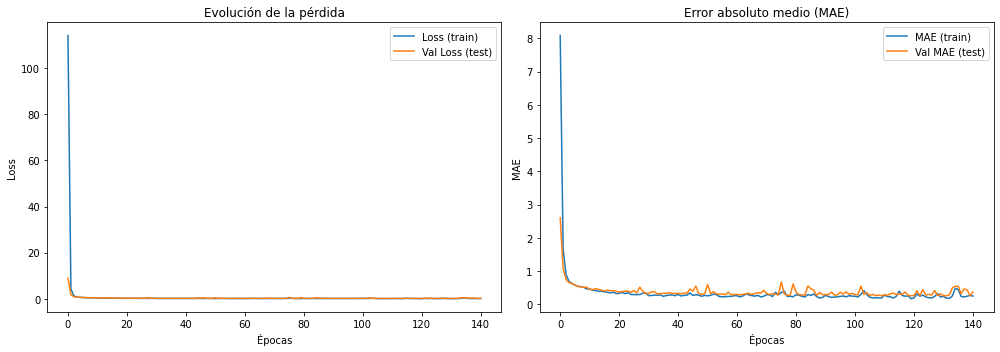

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir el historial a DataFrame
history_df = pd.DataFrame(history.history)

# Graficar la pérdida
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Loss (train)')
plt.plot(history_df['val_loss'], label='Val Loss (test)')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Graficar MAE
plt.subplot(1, 2, 2)
plt.plot(history_df['mae'], label='MAE (train)')
plt.plot(history_df['val_mae'], label='Val MAE (test)')
plt.title('Error absoluto medio (MAE)')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Hacer predicciones con el modelo sobre el conjunto de test
y_pred = model.predict(X_test).flatten()

# Crear una copia del DataFrame original con las filas correspondientes a X_test
df_test = df_cleaned.iloc[y_test.index].copy()

# Añadir columna con las predicciones
df_test["predic temperatura aula"] = y_pred

output_path = "predicciones_temperatura_aula.csv"
df_test.to_csv(output_path, index=False)
output_path

model.save("model_predict_temperaturas.keras")

df_test

,sensor.sensor_temperatura_1_humidity,sensor.sensor_temperatura_1_pressure,sensor.sensor_temperatura_1_temperature,sensor_puerta_1 Puerta,suma_ventanas_arriba,suma_ventanas_abajo,azimuth_mean,elevacion_sol,temperatura_exterior,porcentaje_nubes,...,dia_4,dia_5,dia_6,dia_1.1,dia_2.1,dia_3.1,dia_4.1,dia_5.1,dia_6.1,predic temperatura aula
1525,45.90,1002.20,18.07,0.0,0.0,0.0,265.20,7.36,17.6,27.0,...,False,True,False,0,0,0,0,1,0,19.084759
1026,53.78,1010.65,21.42,471.0,3600.0,14400.0,184.57,38.48,15.5,1.0,...,False,False,False,0,0,0,0,0,0,22.041618
354,52.05,1015.40,12.99,0.0,0.0,0.0,227.73,11.09,17.7,67.0,...,True,False,False,0,0,0,1,0,0,14.026849
669,47.37,1013.33,21.13,0.0,0.0,0.0,227.73,15.75,20.0,0.0,...,True,False,False,0,0,0,1,0,0,22.891392
643,47.34,1006.40,21.73,2800.0,0.0,0.0,265.95,-26.55,16.8,27.0,...,False,False,False,0,1,0,0,0,0,23.065052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,50.58,1015.10,20.99,0.0,0.0,0.0,141.31,18.01,14.4,98.0,...,False,False,False,0,0,1,0,0,0,20.954330
1298,67.29,1007.65,18.83,0.0,3600.0,14400.0,237.21,26.62,14.8,76.0,...,True,False,False,0,0,0,1,0,0,20.637995
58,42.77,1025.70,17.59,0.0,0.0,0.0,265.87,-33.18,12.4,82.0,...,False,True,False,0,0,0,0,1,0,19.528732
736,44.73,1017.45,20.39,792.0,0.0,0.0,116.07,3.10,11.1,48.0,...,False,False,False,0,1,0,0,0,0,20.167013
